# Decision Tree ID3 Algorithm

### import package

In [2]:
"""
@author: songwen
"""
from numpy import *
import numpy as np
import pandas as pd
from math import log
import matplotlib.pyplot as plt
import matplotlib

In [3]:
# matplotlib.rcParams['font.sans-serif'] = [u'SimHei']
# matplotlib.rcParams['axes.unicode_minus'] = False
'''
Calculate the information entropy (Information Gain) gain function of the data set (the information entropy in machine learning is called Shannon entropy)
'''


def calcInfoEnt(dataSet):  # In this question, each column of the Label category #dataSet is an attribute (the end of the column is Label)
    numEntries = len(dataSet)  # Each row is a sample
    labelCounts = {}  # Create a dictionary labelCounts initial value {key:value...} for all possible categories, so as to count the number of class A and the number of class B.

    for featVec in dataSet:  # Loop by row: that is, featVev traverses each row in the dataset
        currentLabel = featVec[-1]  # featVec[-1] traverses the last column value that is Label
        if currentLabel not in labelCounts.keys():  # If the current Label is not yet in the dictionary, it will be created when a category is found, or it will be counted when a category is found.
            labelCounts[currentLabel] = 0  # Then assign 0 first to create the word, dictionary form.
        labelCounts[currentLabel] += 1  # Count, count the number of Labels of each type (this line is not limited by if), the value is 1, the key will be counted by +1, if the currentLabel is not added, it will start counting from 0.

    InfoEnt = 0.0
    for key in labelCounts:  # Iterate over each type of Label
        prob = float(labelCounts[key]) / numEntries  # Various Label entropy accumulation
        InfoEnt -= prob * log(prob, 2)  # The information gain formula used by ID3, the smaller the value, the higher the purity.
    return InfoEnt


'''
For discrete features: take out all samples with the feature value as value
'''


def splitDiscreteDataSet(dataSet, axis, value):  # dataSet is the current node (to be divided) collection, list
    # axis indicates the attribute on which the division is based, which is the column number of the divided attribute, such as 0, 1, 2...
    # value This attribute is used to divide the value, and the attribute value corresponds to a string
    # That is to say, the axis pair divides the attribute, the value is the specific value a1, a2, a3... of this attribute, and the training set samples are divided according to these attribute values.
    # For example: texture-clear corresponds to sample D1, texture-slightly blurred corresponds to sample D2, texture-blurred sample D3. Divide the current data set D into 3 parts.
    retDataSet = []  # Allocate a list for return Data Set to store
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]  # Features prior to this feature remain in the sample dataset
            reducedFeatVec.extend(featVec[axis + 1:])  # The features after this feature remain in the sample dataSet, and extend() adds the number of columns!
            # These two sentences mean that the current division of the axis column is removed, and the remaining sample set is shown in the example in the penultimate paragraph of "Machine Learning" P77.

            retDataSet.append(reducedFeatVec)  # Add this sample to the list and remove this division attribute
    return retDataSet


'''
The continuous value can be used as the dividing point in a loop (the number remains unchanged), and the optimal dividing point selected in the discrete value is thrown away after use, and is no longer used.
For continuous features: return all samples whose feature value is greater than value (divide the set into two parts with value as the threshold)
'''


def splitContinuousDataSet(dataSet, axis, value):
    retDataSetG = []  # will store samples whose value is greater than value
    retDataSetL = []  # will store samples whose value is less than value
    for featVec in dataSet:
        if featVec[axis] > value:  # If it is greater than the threshold, the columns of the matched sample data are from [0,axis)U[axis+1,end),
            # Still the same as discrete values, remove the division attribute, except that the division attribute is a continuous value.
            reducedFeatVecG = featVec[:axis]
            reducedFeatVecG.extend(featVec[axis + 1:])
            retDataSetG.append(reducedFeatVecG)  # Remove the partition attribute column and merge it into a list
        else:
            reducedFeatVecL = featVec[:axis]
            reducedFeatVecL.extend(featVec[axis + 1:])
            retDataSetL.append(reducedFeatVecL)
    return retDataSetG, retDataSetL  # Returns two sets, in tuple form with 2 elements


'''
Select the current best partition feature (and what value to partition for continuous variables) based on InfoGain
'''


def chooseBestFeatureToSplit(dataSet, labels):
    numFeatures = len(dataSet[0]) - 1  # The number of attributes in row 0 is 8, and the last category is removed
    baseEntropy = calcInfoEnt(dataSet)  # Calculate the information entropy of the dataset
    bestInfoGain = 0.0;
    bestFeature = -1  # Initialize the best split point (maximum information gain value) and the best feature
    bestSplitDict = {}  # Initialize the best partition dictionary set
    for i in range(numFeatures):
        # Traverse all features: The following sentence is to take the ith of each row, that is, to get the value of the ith feature of all samples in the current set
        featList = [example[i] for example in dataSet]
        # Determine whether it is a discrete feature
        if not (type(featList[0]).__name__ == 'float' or type(featList[0]).__name__ == 'int'):
            ### For discrete features: find the entropy increase if divided by this feature
            uniqueVals = set(featList)  # Create a set from a list (get the value of the unique element of the list)
            newEntropy = 0.0
            for value in uniqueVals:  # Traverse each value of the discrete feature, and find the entropy of each different value of the i-th column attribute*their probability
                subDataSet = splitDiscreteDataSet(dataSet, i, value)  # Calculate the information entropy of each value
                prob = len(subDataSet) / float(len(dataSet))  # subDataSet is to remove the remaining samples that match the divided attribute values.
                newEntropy += prob * calcInfoEnt(subDataSet)  # Entropy accumulation of each value of the attribute

            infoGain = baseEntropy - newEntropy  # Get the entropy increase divided by this feature
        ### For continuous features: find the entropy increase if divided by this feature (difference: n-1 candidate division points need to be added for n data, and the best division point is selected)
        else:
            # Generate n-1 candidate division points: For example, 0.3, 0.7, 0.8 to find 2 averages: 0.5, 0.75. 2 consecutive points become 1 division point, 3 consecutive values are 2 division points, so n changes into n-1 division points. It is enough to examine the best dividing point for this new sequence.
            sortfeatList = sorted(featList)
            splitList = []  # Used to store n-1 division points
            for j in range(len(sortfeatList) - 1):  # Generate n-1 candidate partition points
                splitList.append((sortfeatList[j] + sortfeatList[j + 1]) / 2.0)
            bestSplitEntropy = 10000  # Set a large entropy value (for later use)
            # Traverse n-1 candidate division points: find the entropy increase when selecting the jth candidate division point for division, and select the best division point
            for j in range(len(splitList)):  # The dividing points are already the respective medians
                value = splitList[j]
                newEntropy = 0.0
                DataSet = splitContinuousDataSet(dataSet, i, value)
                subDataSetG = DataSet[0]
                subDataSetL = DataSet[1]
                probG = len(subDataSetG) / float(len(dataSet))
                newEntropy += probG * calcInfoEnt(subDataSetG)
                probL = len(subDataSetL) / float(len(dataSet))
                newEntropy += probL * calcInfoEnt(subDataSetL)  # Information entropy of a node D after removing a partition attribute
                if newEntropy < bestSplitEntropy:  # At the beginning, the first candidate entropy is the smallest by default, and then compared with the following ones, the small one replaces the current entropy.
                    bestSplitEntropy = newEntropy
                    bestSplit = j  # At this time, the information entropy of the j division points is the smallest
            bestSplitDict[labels[i]] = splitList[bestSplit]  # The dictionary records the best dividing point of the current continuous attribute

            infoGain = baseEntropy - bestSplitEntropy  # Calculate the entropy increase divided by this node
        ### Choose among all attributes (both continuous and discrete) which will give the largest entropy increase
        if infoGain > bestInfoGain:
            bestInfoGain = infoGain
            bestFeature = i
    # If the optimal division feature of the current node is a continuous feature, it needs to be binarized according to "whether it is less than or equal to its optimal division point"
    # Change the feature to "whether it is less than or equal to bestSplitValue", for example, change "density" to "density <=0.3815"
    # Note: The following paragraph directly manipulates the original dataSet data, and the previous float values become 0 and 1 accordingly
    # [Why do this?] You will see the explanation at the end of the function createTree(), which is the binarization of discrete values.
    if type(dataSet[0][bestFeature]).__name__ == 'float' or \
            type(dataSet[0][bestFeature]).__name__ == 'int':
        bestSplitValue = bestSplitDict[
            labels[bestFeature]]  # The key-value pair in the dictionary is the best split attribute: the corresponding value labels[bestFeature] is the Density attribute, and bestSplitValue is 0.381499999
        labels[bestFeature] = labels[bestFeature] + '<=' + str(bestSplitValue)  # Density <= 0.38149999999999995
        for i in range(shape(dataSet)[0]):
            if dataSet[i][bestFeature] <= bestSplitValue:
                dataSet[i][bestFeature] = 1  # If the density of the sample is less than the best dividing point, change the discrete attribute value to 1, otherwise change it to 0
            else:
                dataSet[i][bestFeature] = 0
    return bestFeature


'''
If the features have been divided and the samples under the node have not been uniformly valued, a vote is required: calculate the number of Labels of each type, and take the max.
'''


def majorityCnt(classList):
    # print(classList)
    classCount = {}  # A dictionary with keys of type Label will be created
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0  # The first occurrence of Label is added to the dictionary
        classCount[vote] += 1  # count
    return max(classCount)


'''
    #Main program: recursively generate decision tree
    # dataSet: The data set currently used to build the tree, which is data_full at the beginning, and then gets smaller and smaller as the division progresses.
    # labels: the categories used for division in the current dataset

'''
numLine = numColumn = 2


def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]  # Extract the categories in the last column of the dataset.
    # Recursive stop condition 1: All samples of the current node belong to the same class; (Note: the count() method counts the number of times an element appears in the list), of course, don't divide it, because the ID3 decision tree is used for classification, and all D are The same category, why do you have to divide it? It's almost divided!
    # print(classList)
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    # Recursive stop condition 2: The sample set on the current node is an empty set (that is, there is no sample on a certain value of the feature):
    global numLine, numColumn
    (numLine, numColumn) = shape(dataSet)  # It starts with (17, 9) followed by (5, 8). . .
    if float(numLine) == 0:
        return 'empty'
    # Recursive stop condition 3: All features that can be used for division have been used, then call majorityCnt() to vote for Label;
    # No remaining attributes can be used to further divide the sample. in this case. Using majority voting, convert a given node into a leaf, and use the category with the largest number of tuples in the sample as the category mark, and also store the category distribution of the node sample
    if float(numColumn) == 1:  # There is only one column of attributes, of course, there is no need to divide attributes.
        return majorityCnt(classList)
    # Continue dividing without stopping:
    bestFeat = chooseBestFeatureToSplit(dataSet, labels)  # Call the function to find out which is the current best segmentation feature
    bestFeatLabel = labels[bestFeat]  # The current best segmentation feature
    myTree = {bestFeatLabel: {}}  # The tree stores the division points and corresponding category labels in the form of a dictionary.
    featValues = [example[bestFeat] for example in dataSet]  # All attributes of the sample divided under bestFeature
    uniqueVals = set(featValues)
    if type(dataSet[0][bestFeat]).__name__ == 'str':  # The 0th row sample of the data set, the best divided attribute column, the corresponding attribute value is the judgment of 'str' type.
        currentlabel = labels_full.index(labels[bestFeat])  # Find the column number that divides the attribute.
        featValuesFull = [example[currentlabel] for example in dataSet]  # All attribute values of the division point
        uniqueValsFull = set(featValuesFull)  # All attribute values of the current optimal division point can be included, for example, the first time is the three attribute values of Texture's {'fuzzy', 'distinct', 'blur'}.
    del (labels[bestFeat])  # After the division, that is, the current feature has been used, so it is deleted from the corresponding position in the "feature set to be divided"
    # Recursive call] For each value of the feature currently used for division (bestFeat), divide a subtree.
    for value in uniqueVals:  # Traverse the feature [existing] values
        subLabels = labels[:]  # List of labels left after deleting the partition attribute
        if type(dataSet[0][bestFeat]).__name__ == 'str':
            uniqueValsFull.remove(value)  # Delete after division (delete from uniqueValsFull!)
        myTree[bestFeatLabel][value] = createTree(splitDiscreteDataSet(dataSet, bestFeat, value), subLabels)
        # 用splitDiscreteDataSet()This is because all continuous features are processed into discrete values by the chooseBestFeatureToSplit() defined by us after division.
    if type(dataSet[0][bestFeat]).__name__ == 'str':  # If the feature is discrete
        for value in uniqueValsFull:  # then there may be some values that are no longer in the [existing] values
            # This is why the above is removed from "uniqueValsFull"
            # Because the values of the feature that are not obtained in the existing data set are retained in it
            myTree[bestFeatLabel][value] = majorityCnt(classList)
    return myTree



### Draw a Tree

In [4]:
decisionNode = dict(boxstyle='sawtooth', fc='0.8')
leafNode = dict(boxstyle='round4', fc='0.8')
arrow_args = dict(arrowstyle='<-')


def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    """draw a node with an arrow"""
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction', xytext=centerPt, textcoords='axes fraction',
                            va='center', ha='center', bbox=nodeType, arrowprops=arrow_args)


def createPlot():
    """draw tree nodes"""
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    createPlot.ax1 = plt.subplot(111, frameon=False)
    plotNode('decision node', (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode('leaf node', (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()


def getNumLeafs(myTree):
    """Get the number of leaf nodes"""
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs


def getTreeDepth(myTree):
    """Get the level of the tree"""
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth


def plotMidText(cntPt, parentPt, txtString):
    """Fill text information between parent and child nodes"""
    xMid = (parentPt[0] - cntPt[0]) / 2 + cntPt[0]
    yMid = (parentPt[1] - cntPt[1]) / 2 + cntPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)


def plotTree(myTree, parentPt, nodeTxt):
    """draw tree diagram"""
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1 + float(numLeafs)) / 2 / plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1 / plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1 / plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1 / plotTree.totalD


def createPlot(inTree):
    """Create drawing area"""
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5 / plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()


In [5]:
'''Spanning Tree Called Statements'''  ###########################################################

from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)


### Data Preprocessing - Data Discretization

In [6]:
from sklearn.preprocessing import KBinsDiscretizer
kbd = KBinsDiscretizer(strategy="uniform", n_bins=5, encode="ordinal")
df_transformed = kbd.fit_transform(df.iloc[:,0:4])
print(df_transformed)

[[1. 3. 0. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 0.]
 [0. 3. 0. 0.]
 [1. 3. 0. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 0.]
 [0. 1. 0. 0.]
 [0. 2. 0. 0.]
 [1. 3. 0. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 0.]
 [2. 4. 0. 0.]
 [1. 4. 0. 0.]
 [1. 3. 0. 0.]
 [1. 3. 0. 0.]
 [1. 3. 0. 0.]
 [1. 3. 0. 0.]
 [1. 2. 0. 0.]
 [1. 3. 0. 0.]
 [0. 3. 0. 0.]
 [1. 2. 0. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 0.]
 [1. 3. 0. 0.]
 [1. 2. 0. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 0.]
 [1. 2. 0. 0.]
 [1. 4. 0. 0.]
 [1. 4. 0. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 0.]
 [1. 3. 0. 0.]
 [0. 3. 0. 0.]
 [0. 2. 0. 0.]
 [1. 2. 0. 0.]
 [0. 3. 0. 0.]
 [0. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 3. 0. 1.]
 [1. 3. 0. 0.]
 [0. 2. 0. 0.]
 [1. 3. 0. 0.]
 [0. 2. 0. 0.]
 [1. 3. 0. 0.]
 [0. 2. 0. 0.]
 [3. 2. 3. 2.]
 [2. 2. 2. 2.]
 [3. 2. 3. 2.]
 [1. 0. 2. 2.]
 [3. 1. 3. 2.]
 [1. 1. 2. 2.]
 [2. 2. 3. 3.]
 [0. 0. 1. 1.]
 [3. 1. 3. 2.]
 [1. 1. 2. 2.]
 [0. 0. 2. 1.]
 [2. 2. 2. 2.]
 [2. 0. 2. 1.]
 [2. 1. 3. 2.]
 [1. 1. 2. 2.]
 [3. 2. 2. 2.]
 [1. 2. 2.

In [7]:
print(kbd.bin_edges_)

[array([4.3 , 5.02, 5.74, 6.46, 7.18, 7.9 ])
 array([2.  , 2.48, 2.96, 3.44, 3.92, 4.4 ])
 array([1.  , 2.18, 3.36, 4.54, 5.72, 6.9 ])
 array([0.1 , 0.58, 1.06, 1.54, 2.02, 2.5 ])]


In [8]:
df.iloc[:,0:4]=df_transformed
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,1.0,3.0,0.0,0.0
1,0.0,2.0,0.0,0.0
2,0.0,2.0,0.0,0.0
3,0.0,2.0,0.0,0.0
4,0.0,3.0,0.0,0.0


In [9]:
df['species'] = iris.target
from sklearn.model_selection import train_test_split

X, y = df.iloc[:, 0:-1].values, df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
data_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
data_train = data_train.values.tolist()
labels = df.columns.values[0:-1].tolist()
print(labels)
myTree = createTree(data_train, labels)
# createPlot(myTree)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


###  Prediction

In [10]:
# forecast data
df1 = pd.DataFrame(X_test)
df1.columns = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
result = []
import re

pattern = r'(.*)<=(.*)'
for hang in range(len(df1)):
    tmpTree = myTree
    while 1:
        key = str()
        for i in tmpTree:
            key = i
        mo = re.search(pattern, key, re.M | re.I)
        if mo:
            lie = mo.group(1)
            v = float(mo.group(2))
            if (df1[lie][hang] <= v):
                tmpTree = tmpTree[i][1]
            else:
                tmpTree = tmpTree[i][0]
        if (type(tmpTree) != dict):
            result.append(tmpTree)
            break
        # prediction accuracy
df1['p_label'] = result
df1['t_label'] = y_test


def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)


acc = accuracy(y_test, result)

print('Percentage of Correct Predictions', acc)

Percentage of Correct Predictions 0.7631578947368421


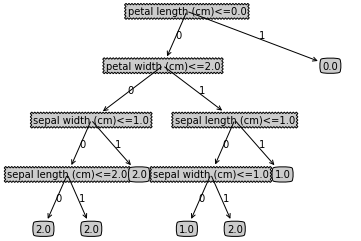

In [11]:
createPlot(myTree)

In [12]:
print(myTree)

{'petal length (cm)<=0.0': {0: {'petal width (cm)<=2.0': {0: {'sepal width (cm)<=1.0': {0: {'sepal length (cm)<=2.0': {0: 2.0, 1: 2.0}}, 1: 2.0}}, 1: {'sepal length (cm)<=1.0': {0: {'sepal width (cm)<=1.0': {0: 1.0, 1: 2.0}}, 1: 1.0}}}}, 1: 0.0}}
